## 참고 블로그의 내용을 옮겨 정리

- https://joungheekim.github.io/2020/11/14/code-review/
- https://arxiv.org/abs/1607.00148
    - 논문을 간단하게 리뷰 
    - pytorch 라이브러리를 이용하여 코드를 구현한 내용 확인

- lstm based autoencoder
    - 시계열 정상데이터를 unsupervised 방법으로 학습하고 이상치를 탐지하는 모델
    - 시계열 데이터가 생성되는 다양한 분야에 보편적으로 적용할 수 있다는 장점을 가지고 있어 활용성이 높은 방법론

## 논문

### 다루는 내용

- 이 논문의 큰 특징 2가지는 아래와 같습니다.
    - LSTM Auto-Encoder를 활용하여 다변량 시계열 데이터를 학습하는 방법을 제시합니다.
    - Unbalanced label 시계열 데이터에 Unsupervised Anomaly Detection 방법론을 적용하는 방법에 대해 제시합니다.

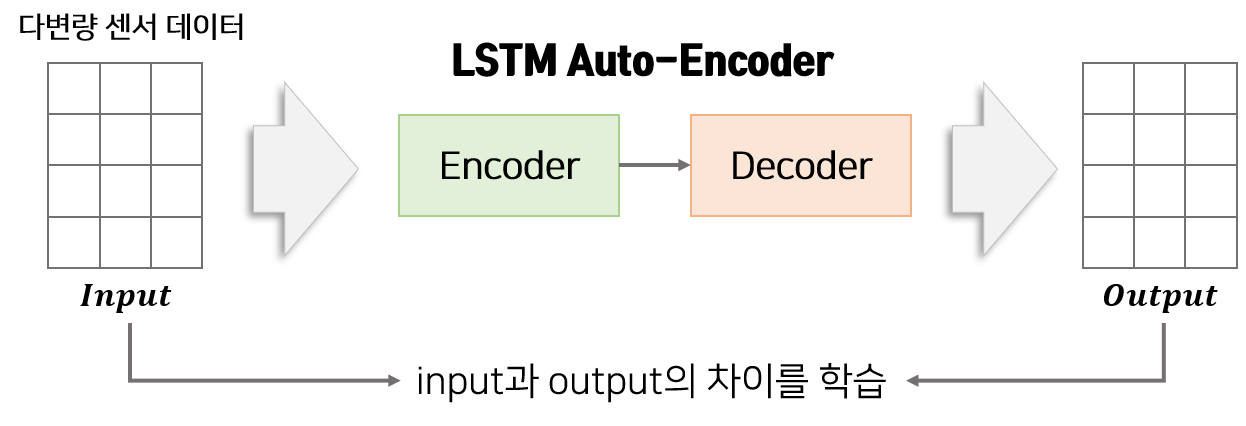

- LSTM Auto-Encoder 모델은 LSTM-Encoder와 LSTM-Decoder로 구성
- Encoder는 다변량 데이터를 압축하여 feature로 변환
- Decoder는 Encoder에서 받은 feature를 이용하여 Encoder에서 받은 다변량 데이터를 재구성
- Encoder의 input과 Decoder에서 나온 output의 차이를 줄이도록 학습함으로써 Auto-Encoder는 정상 데이터의 특징을 압축

### 학습과정

- Encoder의 마지막 step에서 생성된 h_e(t)는 feature vector로 부르며 Decoder의 초기 hidden vector로 활용
- Decoder는 입력으로 Encoder에서 생상한 feature를 받아 original 데이터를 역순으로 재구성
- Decoder는 x(n) x(n-1) x(n-2),,, x(1) 를 차례로 생성
- 이때 decoder의 매 step입력으로 original데이터 역순인 x(t+1)과 이전 step에서 decoder로부터 받은 
  hidden state 벡터인 h_d(t-1)을 활용하여 정보를 압축하여 다음 step의 hidden vector인 h_d(t)를 생성한다. 
- 다음 step의 디코더에 hidden vector h_d(t)를 넘기기전에 fully connected linear layer에 통과시켜 reconstruction 데이터인 x(n-t+1)을 생성
- 오토인코더의 입력과 출력의 차이인 MSE를 최소화하는 방향으로 학습
- 오토인코더를 학습하는 과정에서 이상치가 없는 정상데이터만을 사용한다. 또한 학습과정에서 디코더의 입력으로 오리지날 데이터를 활용하는 teacher forcing테크닉을 적용

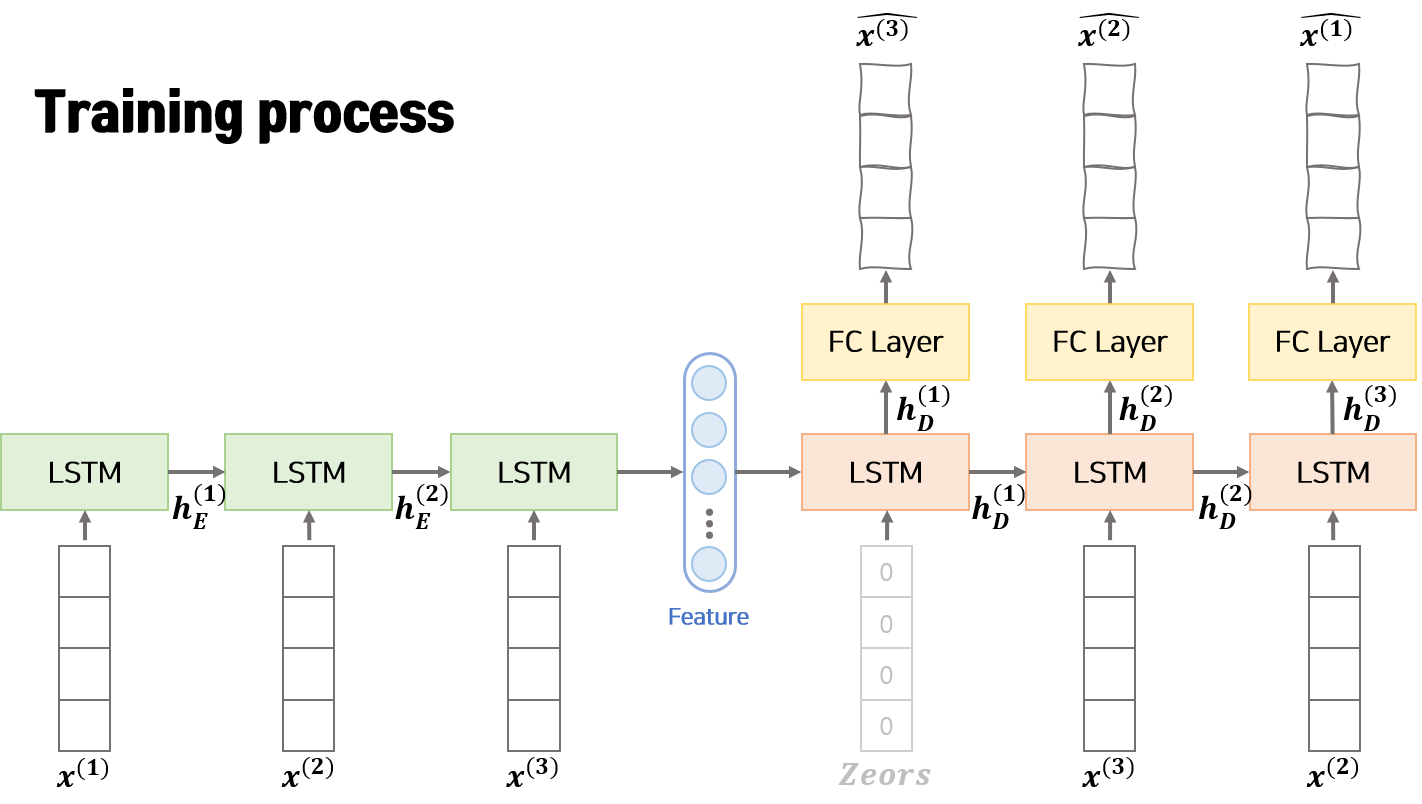


- 학습 목표
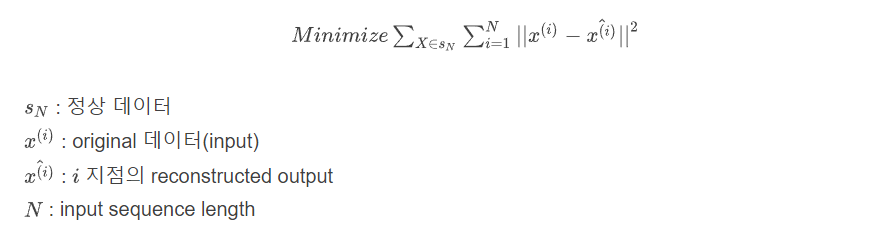

### 추론

- 학습과정과 동일한점 인코더에서 피쳐벡터를 생성하고 디코더의 히든벡터로 인코더의 피쳐벡터를 사용한다는 것
- 다른 점 디코더의 입력으로 오리지날 데이터가 아닌 이전 스텝의 디코더에서 생성된 reconstructed output를 사용한다는것(추정된 값)

- reconstructed error 
    - 학습할때는 mse를 활용하여 학습했지만 추론과정에서 error를 계산하는 방식은 absolute error를 사용하게 된다.
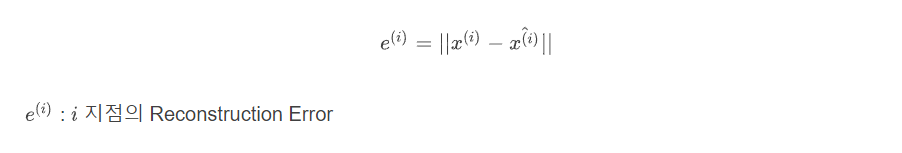

### 데이터 분할

- 데이터는 정상구간(noraml), 비정상구간(abnormal)으로 구성. 
- 본 논문에서는 정상구간을 4개(Sn, Vn, Vn, Tn), 비정상구간을 2개(Va, Ta)로 나누어 학습, 검증, 실험에 활용

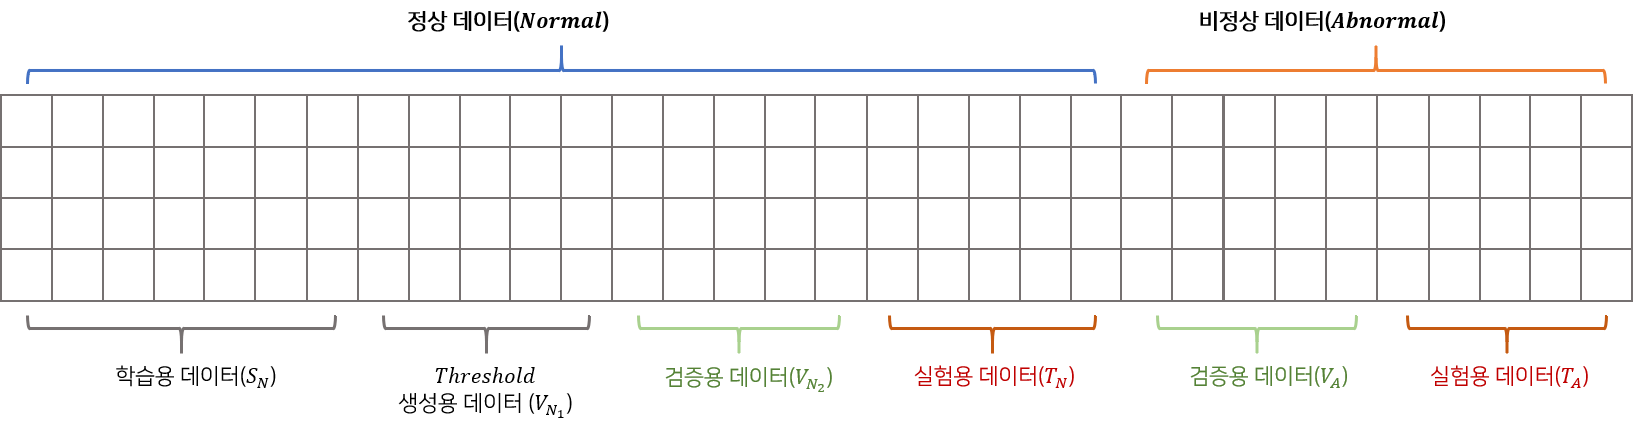

- 학습데이터 
    - 학습용 데이터는 모델을 학습하는데 사용하는 데이터
    - 이 데이터를 활용해 정상구간의 정보를 압축할 수 있도록 모델을 학습
    - 학습된 모델을 활용하면 특정 데이터 구간이 입력으로 들어왔을 때 추론과정을 통해 구간별 reconstruction error를 구할 수 있다.
    
- 파라미터 추정 데이터 
    - 파라미터 추정용 데이터는 reconstruction error의 분포의 파라미터를 추정하는데 활용
    - reconstruction error가 정규분포를 따른다고 가정하고 정규분포의 파라미터 N(mu, sigma)를 MSE를 활용하여 구한다. 
    - 이후 아래 식을 활용해 각 구간의 비정상 점수를 구한다.
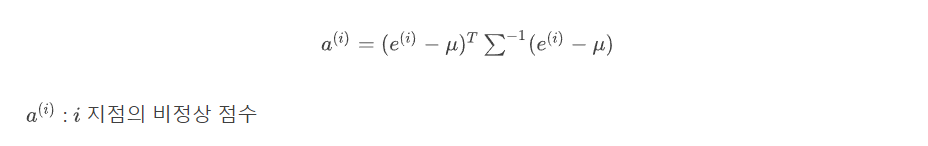

- 검증용 데이터 
    - 학습용 데이터를 이용해 모델을 학습하고, 파라미터 추정 데이터를 통해 비정상을 정의하기 위해 파라미터를 도출 했다. 
    - 이를 활용해 검증용 데이터에서 (Vn2, Va) 비정상 구간과 정상구간을 잘 분류하는지 확인한다. 
    
- 테스트 데이터 
    - 검증 데이터를 통해 최종 학습 모델과 최종 파라미터를 도출한 후 테스트 데이터(Tn, Ta)에서 모델의 최종 성능을 도출한다.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import easydict
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader, Dataset
from celluloid import Camera
import pandas as pd
import pickle
from typing import List
import torch.nn.functional as F

In [2]:
## 데이터 불러오기
df = pd.read_csv('C:/Users/user/Dropbox/Dataset/sensor.csv', index_col=0)
## 데이터 확인
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


  0%|          | 0/52 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


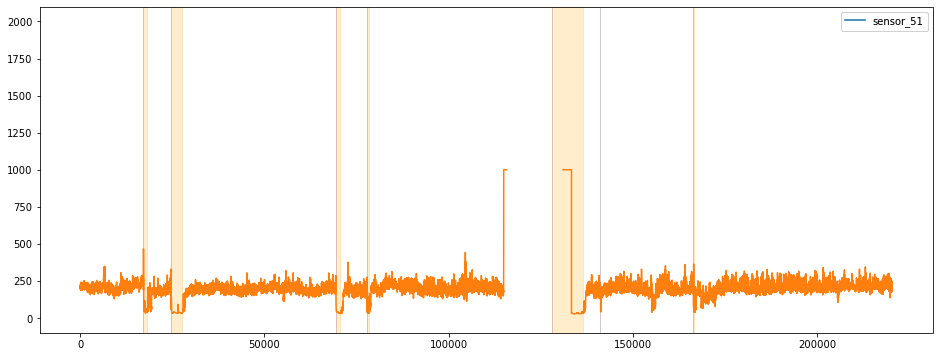

In [3]:
def plot_sensor(temp_df, save_path='sample.gif'):
    fig = plt.figure(figsize=(16, 6))
    ## 에니메이션 만들기
    camera = Camera(fig)
    ax=fig.add_subplot(111)
    
    ## 불량 구간 탐색 데이터
    labels = temp_df['machine_status'].values.tolist()
    dates = temp_df.index
    
    for var_name in tqdm([item for item in df.columns if 'sensor_' in item]):
        ## 센서별로 사진 찍기
        temp_df[var_name].plot(ax=ax)
        ax.legend([var_name], loc='upper right')
        
        ## 고장구간 표시
        temp_start = dates[0]
        temp_date = dates[0]
        temp_label = labels[0]
        
        for xc, value in zip(dates, labels):
            if temp_label != value:
                if temp_label == "BROKEN":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
                if temp_label == "RECOVERING":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
                temp_start=xc
                temp_label=value
            temp_date = xc
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, xc, alpha=0.2, color='orange')
        ## 카메라 찍기
        camera.snap()
        
    animation = camera.animate(500, blit=True)
    # .gif 파일로 저장하면 끝!
    animation.save(
        save_path,
        dpi=100,
        savefig_kwargs={
            'frameon': False,
            'pad_inches': 'tight'
        }
    )
plot_sensor(df)

### 데이터 전처리

In [4]:
## 데이터 Type 변경
df['date'] = pd.to_datetime(df['timestamp'])
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
del df['timestamp']

## date를 index로 변환
df = df.set_index('date')
# df = df.reset_index()

<AxesSubplot:>

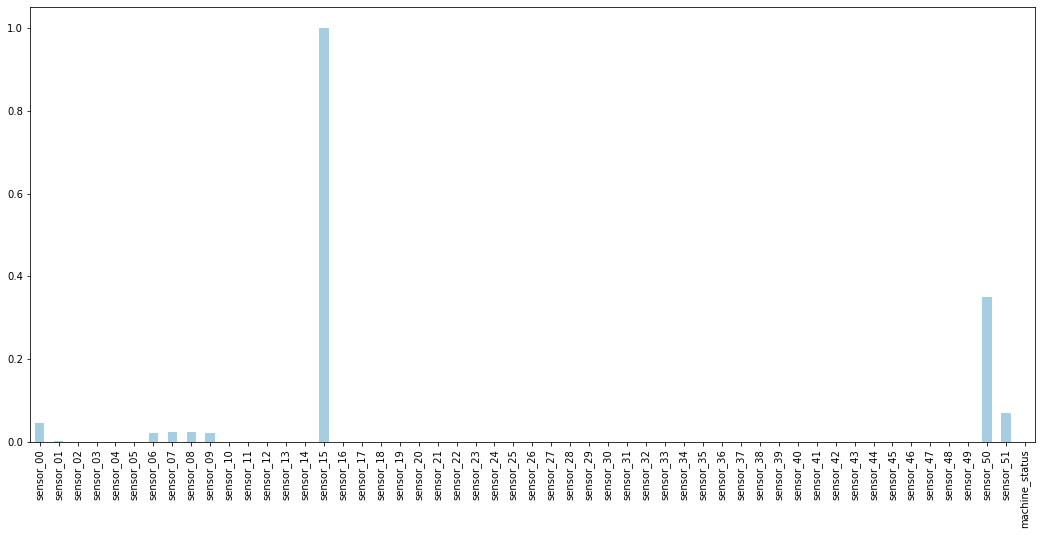

In [5]:
## 결측 변수 확인
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

- 센서15는 모든 구간이 결측데이터이며 센셔 50은 결측비율이 40% 이상이다. 
- 결측비율이 높은 데이터는 정확한 보간이 어려우며 다양한 방법으로 보간을 하더라도 모델의 성능을 하락시키므로 제거한다. 
- 나머지 10%미만의 결측비율을 가지고 있는 6개의 센서 데이터는 한 시점 이전 데이터를 이용해 보간하여 사용한다.

In [6]:
## 중복된 데이터를 삭제
df = df.drop_duplicates()

## 센서 15번, 센서 50 은 삭제
del df['sensor_15']
del df['sensor_50']

## 이전 시점의 데이터로 보간
df = df.fillna(method='ffill')

- 데이터 분리 및 정규화

In [7]:
normal_df = df[df['machine_status']=='NORMAL']
abnormal_df = df[df['machine_status']!='NORMAL']

- 시계열 데이터이므로 셔플을 하지 않고 분리한다. 

In [8]:
## 시계열 데이터이고, 입력의 형태가 특정 길이(window size)의 sequence 데이터 이므로 shuffle은 사용하지 않습니다.
## Normal 데이터는 학습데이터, 파라미터 설정데이터, 검증용데이터, 실험용데이터의 비율을 7:1:1:1 로 나누어서 사용합니다.

interval_n = int(len(normal_df)/10)
normal_df1 = df.iloc[0:interval_n*7]
normal_df2 = df.iloc[interval_n*7:interval_n*8]
normal_df3 = df.iloc[interval_n*8:interval_n*9]
normal_df4 = df.iloc[interval_n*9:]

## abnormal 데이터는 검증용데이터, 실험용데이터의 비율을 5:5 로 나누어서 사용합니다.
interval_ab = int(len(abnormal_df)/2)
abnormal_df1 = df.iloc[0:interval_ab]
abnormal_df2 = df.iloc[interval_ab:]

- 모델은 입려고가 출력의 차이인 mseloss를 이용하여 학습한다.
- 각 센서데이터의 단위차이가 크면 모델은 가장 큰 단위를 가지고 있는 특정 변수의 의존도가 높게 학습된다. 
- 따라서 특정변수의 의존도를 없애고 모델을 로버스트하게 하기 위해 데이터 정규화가 필요하다.
- 학습데이터의 평균과 분산을 추출한뒤 학습 검증 평가시에 정규화에 사용한다.

In [9]:
## 데이터 정규화를 위하여 분산 및 평균 추출
mean_df = normal_df1.mean()
std_df = normal_df1.std()

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


### 데이터 구조 만들기

- 모델은 연속된 시계열 데이터를 이용해 비정상 점수를 산출해야 한다. 
- 따라서 데이터의 연속 여부를 추출하기 위해 make data idx 함수를 만든다.

In [10]:
## 데이터를 불러올 때 index로 불러오기
def make_data_idx(dates, window_size=1):
    input_idx = []
    for idx in range(window_size-1, len(dates)):
        cur_date = dates[idx].to_pydatetime()
        in_date = dates[idx - (window_size-1)].to_pydatetime()
        
        _in_period = (cur_date - in_date).days * 24 * 60 + (cur_date - in_date).seconds / 60
        
        ## 각 index가 1분 간격으로 떨어져 있는지를 확인합니다.
        if _in_period == (window_size-1):
            input_idx.append(list(range(idx - window_size+1, idx+1)))
    return input_idx

- pytorch의 Dataset을 상속받아 데이터 클래스를 구성
- 데이터 클래스는 정규화 과정을 포함

In [11]:
## Dataset을 상속받아 데이터를 구성
class TagDataset(Dataset):
    def __init__(self, input_size, df, mean_df=None, std_df = None, window_size=1):
        
        ## 변수 갯수
        self.input_size = input_size
        
        ## 복원할 sequence 길이
        self.window_size = window_size
        
        ## Summary용 데이터 Deep copy
        original_df = df.copy()
        
        ## 정규화
        if mean_df is not None and std_df is not None:
            sensor_columns = [item for item in df.columns if 'sensor_' in item]
            df[sensor_columns] = (df[sensor_columns]-mean_df)/std_df
        
        ## 연속한 index를 기준으로 학습에 사용.
        dates = list(df.index)
        self.input_ids = make_data_idx(dates, window_size=window_size)
        
        ## sensor 데이터만 사용하여 reconstruct에 활용
        self.selected_column = [item for item in df.columns if 'sensor_' in item][:input_size]
        self.var_data = torch.tensor(df[self.selected_column].values, dtype=torch.float)
        
        ## Summary 용
        self.df = original_df.iloc[np.array(self.input_ids)[:, -1]]
        
    ## Dataset은 반드시 __len__ 함수를 만들어줘야함(데이터 길이)
    def __len__(self):
        return len(self.input_ids)
    
    ## Dataset은 반드시 __getitem__ 함수를 만들어줘야함
    ## torch 모듈은 __getitem__ 을 호출하여 학습할 데이터를 불러옴.
    def __getitem__(self, item):
        temp_input_ids = self.input_ids[item]
        input_values = self.var_data[temp_input_ids]
        return input_values

- 논문에서는 학습 과정에서 origian data를 활용하는 Teacher Forcing 테크닉을 활용하였지만 
- 해당 구현내용은 편의상 학습 과정에서 Decoder의 이전 step의 output을 활용

In [12]:
## 인코더
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return (hidden, cell)
    
## 디코더
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:
        """
        :param input_dim: 변수 Tag 갯수
        :param latent_dim: 최종 압축할 차원 크기
        :param window_size: 길이
        :param kwargs:
        """

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss

In [13]:
def run(args, model, train_loader, test_loader):
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            
            ## MAE(Mean Absolute Error)로 계산
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
            #loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
            loss = loss.mean(dim=1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list

In [14]:
## 하이퍼 파라미터 설정
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 40, ## 입력 차원 설정
    "latent_size": 10, ## Hidden 차원 설정
    "output_size": 40, ## 출력 차원 설정
    "window_size" : 3, ## sequence Lenght
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.001, ## learning rate 설정
    "max_iter" : 100000, ## 총 반복 횟수 설정
    'early_stop' : True,  ## valid loss가 작아지지 않으면 early stop 조건 설정
})

In [15]:
## 데이터셋으로 변환
normal_dataset1 = TagDataset(df=normal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset2 = TagDataset(df=normal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset3 = TagDataset(df=normal_df3, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset4 = TagDataset(df=normal_df4, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset1 = TagDataset(df=abnormal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset2 = TagDataset(df=abnormal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [16]:
## Data Loader 형태로 변환
train_loader = torch.utils.data.DataLoader(
                 dataset=normal_dataset1,
                 batch_size=args.batch_size,
                 shuffle=True)
valid_loader = torch.utils.data.DataLoader(
                dataset=normal_dataset2,
                batch_size=args.batch_size,
                shuffle=False)

In [17]:
## 모델 생성
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=40, bias=True)
  )
)

In [18]:
## 학습하기
model = run(args, model, train_loader, valid_loader)

  0%|          | 0/92 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

training:   0%|          | 0/1087 [00:00<?, ?it/s]

testing:   0%|          | 0/154 [00:00<?, ?it/s]

early stop condition   best_loss[0.09195184144010017]  eval_loss[0.09262884604176144]


In [19]:
## Reconstruction Error를 구하기
loss_list = get_loss_list(args, model, valid_loader)

## Reconstruction Error의 평균과 Covarinace 계산
mean = np.mean(loss_list, axis=0)
std = np.cov(loss_list.T)

testing:   0%|          | 0/154 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [20]:
## Anomaly Score
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], '평균과 분산의 차원이 똑같아야 합니다.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

## 비정상 점수 계산기
anomaly_calculator = Anomaly_Calculator(mean, std)

In [21]:
## Threshold 찾기
anomaly_scores = []
for temp_loss in tqdm(loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

## 정상구간에서 비정상 점수 분포
print("평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))


  0%|          | 0/19620 [00:00<?, ?it/s]

평균[0.05666287852561682], 중간[0.03247861311303224], 최소[0.004086757144346796], 최대[2.292752037058353]


In [22]:
## 전체 데이터 불러오기
total_dataset = TagDataset(df=df, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
total_dataloader = torch.utils.data.DataLoader(dataset=total_dataset,batch_size=args.batch_size,shuffle=False)

## Reconstruction Loss를 계산하기
total_loss = get_loss_list(args, model, total_dataloader)

## 이상치 점수 계산하기
anomaly_scores = []
for temp_loss in tqdm(total_loss):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = total_dataset.df
visualization_df['score'] = anomaly_scores
visualization_df['recons_error'] = total_loss.sum(axis=1)

testing:   0%|          | 0/1655 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/211715 [00:00<?, ?it/s]

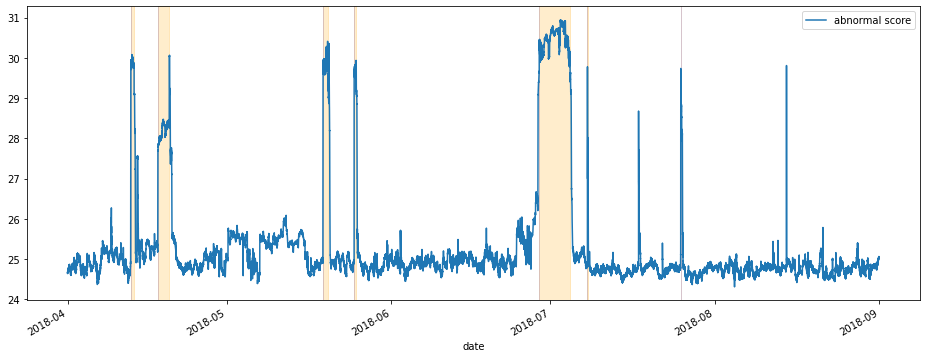

In [23]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['score'].plot(ax=ax)
ax.legend(['abnormal score'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')

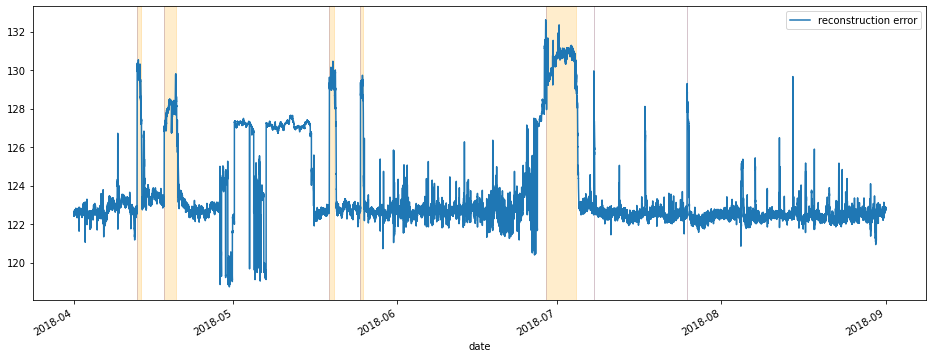

In [24]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['recons_error'].plot(ax=ax)
ax.legend(['reconstruction error'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')